# Segmenting and Clustering Neighborhoods in Toronto
## Week 3 Assignment for Applied Data Science Capstone
### Notebook 3: Clustering Toronto neighborhoods

The dataset was prepared using two previous notebooks and so it is simply read in from a CSV file. 

The segmentation is done in a similar way as was shown in the Lab of Week 2.

#### Import libraries that will be needed for the analysis

In [1]:
import requests
import pandas as pd
import numpy as np
import json
import folium
from sklearn.cluster import KMeans
import seaborn
import matplotlib.pyplot as plt
from tqdm import tqdm   # for loading information
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

My Foursquare credentials are stored in a file that is not shared in the repo for security reasons. 

In [2]:
cred_file = "foursquare_credentials.json"
with open(cred_file, "r") as credfile:
    creds = json.load(credfile)
    CLIENT_ID = creds["client-id"]
    CLIENT_SECRET = creds["client-secret"]
    
VERSION = "20180605"  # To be compatible with the Lab

#### Read in the data set

In [3]:
df_toronto = pd.read_csv("Toronto_LocationData.csv")
df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [4]:
df_toronto.shape

(98, 5)

#### Let's see what this looks like on a map.

In [5]:
# Toronto coordinates: 43.6532° N, -79.3832° W
map_toronto = folium.Map(location=[43.6532, -79.3832], zoom_start=10)

# add markers to map
for lat, lng, label in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### We will call the Foursquare API and retrieve the top 100 venues around each neighborhood
Let's borrow a function from the Lab to retrieve the closest venues. Area of Toronto is approx. 12 times greater than that of Manhattan, so let's increase the search radius. After a few tests, I chose a distance of 1500m, which guaranteed that every neighborhood had venues around it.

In [6]:
def get_nearby_venues(names, latitudes, longitudes, n_venues=100, radius=1500):
    "Retrieves `n_venues` that are within `radius` from the location specified by latitudes and longitudes"
    
    venues_list=[]
    for name, lat, lng in tqdm(zip(names, latitudes, longitudes)):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            n_venues)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']
        ) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return nearby_venues

In [7]:
df_venues = get_nearby_venues(df_toronto['Neighborhood'],
                              df_toronto['Latitude'],
                              df_toronto['Longitude'])

98it [00:41,  2.36it/s]


#### Venues per neighborhood:

In [8]:
df_venues.groupby(['Neighborhood'])['Venue'].count().sort_values(ascending=False)

Neighborhood
Kensington Market, Chinatown, Grange Park    100
Davisville                                   100
Garden District, Ryerson                     100
Christie                                     100
St. James Town, Cabbagetown                  100
                                            ... 
Northwest                                     16
Birch Cliff, Cliffside West                   14
Bayview Village                               14
Rouge Hill, Port Union, Highland Creek        12
Upper Rouge                                    2
Name: Venue, Length: 98, dtype: int64

#### Removing Coffee Shops

While this seems counter-intuitive, after playing with the model for a while, I noticed that almost all neighboorhoods have a lot of coffee shops. This made interepretation of clusters quite difficult. Essentially, by removing Coffee Shops, I am assuming that they are a very common venue category in each neighborhood, which should not sound prepostrous if you have ever been to Toronto and saw all the Tim Horton's shops :)

In [9]:
df_venues = df_venues.loc[df_venues['Venue Category']!='Coffee Shop']

#### Let's perform one hot encoding for the venue categories

In [10]:
# one hot encoding
toronto_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = df_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Zoo Exhibit,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


329 different types of venues!

In [11]:
toronto_onehot.shape

(6120, 342)

#### Find the top 10 most frequent venue categories for each neighborhood. This will be useful later on when we try to identify what each cluster means
I am borrowing quite heavily from the Lab here

In [13]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Zoo Exhibit,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,...,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.022727,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.027778,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.014493,0.0,0.0,0.0,0.0


In [14]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Breakfast Spot,Gym / Fitness Center,Restaurant,Caribbean Restaurant,Food Court,Cantonese Restaurant,Bakery,Hong Kong Restaurant,Shopping Mall
1,"Alderwood, Long Branch",Park,Pharmacy,Burger Joint,Café,Restaurant,Clothing Store,Toy / Game Store,Grocery Store,Bank,Pizza Place
2,"Bathurst Manor, Wilson Heights, Downsview North",Park,Bank,Pizza Place,Gas Station,Fried Chicken Joint,Restaurant,Chinese Restaurant,Baseball Field,Sandwich Place,Sushi Restaurant
3,Bayview Village,Bank,Grocery Store,Trail,Park,Gas Station,Japanese Restaurant,Chinese Restaurant,Café,Restaurant,Farmers Market
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Bakery,Sushi Restaurant,Bagel Shop,Café,Pub,Sandwich Place,Asian Restaurant,Fast Food Restaurant,Pizza Place


#### Now, as in the Lab, let's calculate the frequency for each neighborhood (i.e. such that all values in each row sum to 1.0). These values will be used for K-means clustering algorithm.

In [15]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)  # Drop this column for k-means classification

### Clustering using K-means

Now that we have neighborhoods and their normalized venue category frequencies, we can use k-means clustering. However, what $k$ should we choose? To evaluate that let's try to compare the following two metrics:

1. Sum of squared distances of samples to their closest cluster center - this is readily available in `kmeans.inertia_`
2. [Silhouette Score](https://en.wikipedia.org/wiki/Silhouette_(clustering)), which is a measure of how similar an object is to its own cluster compared to other clusters

In [16]:
from sklearn.metrics import silhouette_score

squared_distances = []
silhouette_scores = []
test_clusters = range(2, 30)

for kclusters in test_clusters:

    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
    squared_distances.append(kmeans.inertia_)
    
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(toronto_grouped_clustering, labels, metric='euclidean')) 


Let's plot the results

Text(0.5, 0, 'k')

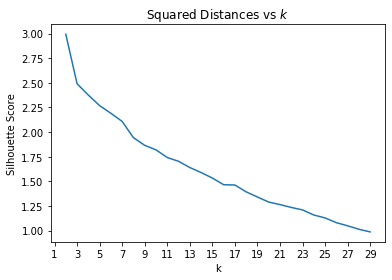

In [17]:
plt.title('Squared Distances vs $k$')
plt.plot(test_clusters, squared_distances)
plt.ylabel('Silhouette Score')
plt.xticks(list(range(1,30))[::2])
plt.xlabel('k')

This one is difficult to interpret, as the squared distance keeps decreasing wiht increasing $k$... Let's  try the other method

Text(0.5, 0, 'k')

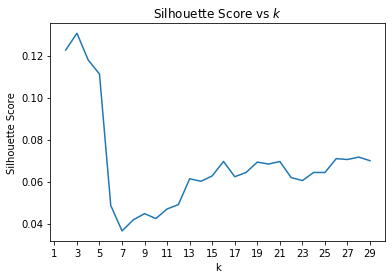

In [18]:
plt.title('Silhouette Score vs $k$')
plt.plot(test_clusters, silhouette_scores)
plt.ylabel('Silhouette Score')
plt.xticks(list(range(1,30))[::2])
plt.xlabel('k')

Choosing $k$=3 would produce the highest score, but considering the number of neighborhoods, that might be a very broad clustering... Let's choose the next maximum, which happens at $k=5$.

Assign the labels back to the original toronto venues DataFrame

In [19]:
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

In [20]:
# add clustering labels
neighborhoods_venues_sorted.loc[:, 'Cluster Labels'] = kmeans.labels_

toronto_merged = df_toronto

# merge toronto_grouped with the original toronto_data 
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,M3A,North York,Parkwoods,43.753259,-79.329656,Pharmacy,Bus Stop,Gas Station,Supermarket,Fast Food Restaurant,Bank,Park,Intersection,Sandwich Place,Café,1
1,M4A,North York,Victoria Village,43.725882,-79.315572,Fast Food Restaurant,Grocery Store,Gym,Middle Eastern Restaurant,Hockey Arena,Bank,Beer Store,Bookstore,Food,Spa,1
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Café,Park,Restaurant,Diner,Pub,Thai Restaurant,Italian Restaurant,Japanese Restaurant,Bar,Farmers Market,0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Clothing Store,Fast Food Restaurant,Restaurant,Sandwich Place,Dessert Shop,Furniture / Home Store,Vietnamese Restaurant,Latin American Restaurant,Greek Restaurant,Toy / Game Store,1
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Café,Japanese Restaurant,Ramen Restaurant,Gastropub,Park,Restaurant,Dance Studio,Supermarket,Theater,Thai Restaurant,0


#### Let's plot the clusters

In [21]:
map_clusters = folium.Map(location=[43.6532, -79.3832], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',#rainbow[cluster-1],
        fill=True,
        weight=1,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9,).add_to(map_clusters)
       
map_clusters

### Interpretation of the different segments

In order to interpret the segments, let's print out each category and most frequent categories in the Top 3

In [22]:
def check_top_3_venues(category):
    "Helper function to print Top 3 most frequent areas for neighborhoods in each category"
    
    df_temp = toronto_merged.loc[toronto_merged['Cluster Labels']==category]
    top_3_cols = df_temp.columns[-11:-8]
    for col in top_3_cols:
        print('-'*80)
        print(col)
        print('-'*80)
        val_counts_i = df_temp[col].value_counts(ascending=False)
        print(val_counts_i.head(5).to_string())


Let's print out all the venue categories in each cluster

In [23]:
for cat in range(kclusters):
    print('='*80)
    print(f'\t\t\t>>>> Category label #{cat} <<<')
    print('='*80)
    check_top_3_venues(cat)

			>>>> Category label #0 <<<
--------------------------------------------------------------------------------
1st Most Common Venue
--------------------------------------------------------------------------------
Café                  17
Park                  10
Italian Restaurant     8
Hotel                  3
Korean Restaurant      2
--------------------------------------------------------------------------------
2nd Most Common Venue
--------------------------------------------------------------------------------
Café          10
Park           6
Bakery         5
Hotel          4
Restaurant     3
--------------------------------------------------------------------------------
3rd Most Common Venue
--------------------------------------------------------------------------------
Park                  7
Pizza Place           5
Sushi Restaurant      4
Italian Restaurant    4
Bar                   3
			>>>> Category label #1 <<<
----------------------------------------------------------

#### So, making very broad conclusions:  
0. Area with most cafes and parks - this is probably an area a little further away from the downtown with more space for parks
1. Best area to find a pizza place, bank, or a pharmacy - this is probably the midtown and downtown area
2. A very unique neighborhood with a zoo, farm, and a national park
3. Area dominated by Chineese restaurants (as a percentage of all venues there)
4. A very unique neighborhood with a zoo exhibit
